## Load dataset

In [86]:
import pandas as pd

# Define the file path
file_path = "/content/car.data"

# Define column names for the dataset
columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']

# Load the data
car_data = pd.read_csv(file_path, header=None, names=columns)

# Display the head of the dataset
print(car_data.head())

  buying  maint doors persons lug_boot safety  class
0  vhigh  vhigh     2       2    small    low  unacc
1  vhigh  vhigh     2       2    small    med  unacc
2  vhigh  vhigh     2       2    small   high  unacc
3  vhigh  vhigh     2       2      med    low  unacc
4  vhigh  vhigh     2       2      med    med  unacc


## Display dataset statistics

In [87]:
# Display basic information about the dataset
print("Basic Information:")
print(car_data.info())

# Display descriptive statistics
print("\nDescriptive Statistics:")
print(car_data.describe(include=[object]))

print("Number of duplicate rows:", car_data.duplicated().sum())
car_data = car_data.drop_duplicates()

print("Number of missing values:", car_data.isnull().sum().sum())

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB
None

Descriptive Statistics:
       buying  maint doors persons lug_boot safety  class
count    1728   1728  1728    1728     1728   1728   1728
unique      4      4     4       3        3      3      4
top     vhigh  vhigh     2       2    small    low  unacc
freq      432    432   432     576      576    576   1210
Number of duplicate rows: 0
Number of missing values: 0


In [88]:
# Print unique values in each column
print("\nUnique values in each column:")
for column in car_data.columns:
    print(f"Unique values in column '{column}': {car_data[column].unique()}")

Unique values in column 'buying': ['vhigh' 'high' 'med' 'low']
Unique values in column 'maint': ['vhigh' 'high' 'med' 'low']
Unique values in column 'doors': ['2' '3' '4' '5more']
Unique values in column 'persons': ['2' '4' 'more']
Unique values in column 'lug_boot': ['small' 'med' 'big']
Unique values in column 'safety': ['low' 'med' 'high']
Unique values in column 'class': ['unacc' 'acc' 'vgood' 'good']


In [89]:
print("\nDistribution of class variable:")
print(car_data['class'].value_counts())

class
unacc    1210
acc       384
good       69
vgood      65
Name: count, dtype: int64


## Data preprocessing

In [90]:
import pandas as pd
from imblearn.over_sampling import SMOTE

# Replace '5more' and 'more' in the dataset
car_data['doors'] = car_data['doors'].replace('5more', '5').astype(int)
car_data['persons'] = car_data['persons'].replace('more', '5').astype(int)

# One-hot encode categorical columns
car_data_encoded = pd.get_dummies(
    car_data,
    columns=['buying', 'maint', 'lug_boot', 'safety'],
    drop_first=True
)

# Binary classification mapping for 'class'
car_data_encoded['class'] = car_data_encoded['class'].replace(
    {'unacc': 0, 'acc': 1, 'good': 1, 'vgood': 1}
)


# Separate features and target
X = car_data_encoded.drop(columns=['class'])
y = car_data_encoded['class']

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Verify the new class distribution
print("Class distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())

Class distribution after SMOTE:
class
0    1210
1    1210
Name: count, dtype: int64


<ipython-input-90-ffd1ac559e7e>:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  car_data_encoded['class'] = car_data_encoded['class'].replace(


### Final data after processing

In [91]:
# Combine resampled features and target into a single DataFrame
final_data = pd.DataFrame(X_resampled, columns=X.columns)
final_data['class'] = y_resampled

# Display the first few rows of the final dataset
print(final_data.head(2))

   doors  persons  buying_low  buying_med  buying_vhigh  maint_low  maint_med  \
0      2        2       False       False          True      False      False   
1      2        2       False       False          True      False      False   

   maint_vhigh  lug_boot_med  lug_boot_small  safety_low  safety_med  class  
0         True         False            True        True       False      0  
1         True         False            True       False        True      0  


## Data preparation for modeling

In [92]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming `final_data` is your preprocessed DataFrame
X = final_data.drop(columns=["class"])  # Features
y = final_data["class"]  # Target variable

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for consistency in feature names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print("Train-Test Split and Scaling Complete.")
print(f"Train Shape: {X_train_scaled.shape}, Test Shape: {X_test_scaled.shape}")

Train-Test Split and Scaling Complete.
Train Shape: (2178, 12), Test Shape: (242, 12)


# Modeling

## Random Forest with tuning

In [93]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Random Forest parameter grid for GridSearchCV
param_grid_rf = {
    "n_estimators": [50, 100, 150],
    "min_samples_split": [2, 5, 10],
}

# Create the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Perform GridSearchCV for hyperparameter tuning
grid_search_rf = GridSearchCV(
    estimator=rf_classifier, param_grid=param_grid_rf, cv=3, scoring="accuracy", n_jobs=-1
)
grid_search_rf.fit(X_train_scaled, y_train)

# Best parameters and training
best_rf_params = grid_search_rf.best_params_
rf_model = RandomForestClassifier(**best_rf_params, random_state=42)
rf_model.fit(X_train_scaled, y_train)

print("Random Forest Training Complete.")
print("Best Parameters:", best_rf_params)

Random Forest Training Complete.
Best Parameters: {'min_samples_split': 5, 'n_estimators': 50}


## LSTM model

In [94]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Reshaping data for LSTM (samples, timesteps, features)
X_train_lstm = np.expand_dims(X_train_scaled.values, axis=-1)
X_test_lstm = np.expand_dims(X_test_scaled.values, axis=-1)

# Building the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(64, activation="relu", input_shape=(X_train_lstm.shape[1], 1)))
lstm_model.add(Dense(1, activation="sigmoid"))

# Compile the model
lstm_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, verbose=1)

print("LSTM Training Complete.")

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5479 - loss: 0.6837
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7457 - loss: 0.5683
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8674 - loss: 0.3159
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8941 - loss: 0.2563
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9082 - loss: 0.2290
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9161 - loss: 0.2058
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9185 - loss: 0.1943
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9316 - loss: 0.1792
Epoch 9/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9280 - loss: 0.1826
Epoch 10/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9331 - loss: 0.1734
Epoch 11/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8882 - loss: 0.2636
Epoch 12/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9447 - loss: 0.

## KNN with tuning

In [95]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# KNN parameter grid for GridSearchCV
param_grid_knn = {
    "n_neighbors": list(range(1, 15)),
}

# Create the KNN classifier
knn_classifier = KNeighborsClassifier()

# Perform GridSearchCV for hyperparameter tuning
grid_search_knn = GridSearchCV(
    estimator=knn_classifier, param_grid=param_grid_knn, cv=3, scoring="accuracy", n_jobs=-1
)
grid_search_knn.fit(X_train_scaled, y_train)

# Best parameters and training
best_knn_params = grid_search_knn.best_params_
knn_model = KNeighborsClassifier(**best_knn_params)
knn_model.fit(X_train_scaled, y_train)

print("KNN Training Complete.")
print("Best Parameters:", best_knn_params)

KNN Training Complete.
Best Parameters: {'n_neighbors': 1}


## Defining helper functions and variables

In [96]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score, brier_score_loss, classification_report

# Initialize Stratified K-Fold
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# To store metrics for each fold and each model
metrics_rf = []
metrics_knn = []
metrics_lstm = []

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, y_prob):
    cm = confusion_matrix(y_true, y_pred)
    TP, FN = cm[1, 1], cm[1, 0]
    FP, TN = cm[0, 1], cm[0, 0]

    # Metrics
    TPR = TP / (TP + FN)  # Sensitivity
    TNR = TN / (TN + FP)  # Specificity
    FPR = FP / (FP + TN)
    FNR = FN / (TP + FN)
    Precision = TP / (TP + FP)
    Accuracy = (TP + TN) / (TP + TN + FP + FN)
    F1 = 2 * TP / (2 * TP + FP + FN)
    AUC = roc_auc_score(y_true, y_prob)
    Brier = brier_score_loss(y_true, y_prob)

    # True Skill Statistic (TSS) and Heidke Skill Score (HSS)
    TSS = TPR - FPR
    HSS = 2 * (TP * TN - FP * FN) / ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN))

    metrics = {
        "TPR (Recall)": TPR,
        "TNR (Specificity)": TNR,
        "FPR": FPR,
        "FNR": FNR,
        "Precision": Precision,
        "F1-Score": F1,
        "Accuracy": Accuracy,
        "TSS": TSS,
        "HSS": HSS,
        "AUC": AUC,
        "Brier Score": Brier,
    }
    return metrics

# Convert metrics to DataFrame for all folds
folds_metrics_rf = pd.DataFrame(metrics_rf)
folds_metrics_knn = pd.DataFrame(metrics_knn)
folds_metrics_lstm = pd.DataFrame(metrics_lstm)

# Add Fold Index for Clarity
folds_metrics_rf.index = [f"Fold {i+1}" for i in range(len(metrics_rf))]
folds_metrics_knn.index = [f"Fold {i+1}" for i in range(len(metrics_knn))]
folds_metrics_lstm.index = [f"Fold {i+1}" for i in range(len(metrics_lstm))]

# Add Average Row
folds_metrics_rf.loc["Average"] = folds_metrics_rf.mean()
folds_metrics_knn.loc["Average"] = folds_metrics_knn.mean()
folds_metrics_lstm.loc["Average"] = folds_metrics_lstm.mean()

## Training and Testing best models

In [97]:
for train_idx, test_idx in kf.split(X_train_scaled, y_train):
    # Splitting the data
    X_train_fold, X_test_fold = X_train_scaled.iloc[train_idx], X_train_scaled.iloc[test_idx]
    y_train_fold, y_test_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]

    # Train and predict
    rf_model.fit(X_train_fold, y_train_fold)
    y_pred_rf = rf_model.predict(X_test_fold)
    y_prob_rf = rf_model.predict_proba(X_test_fold)[:, 1]

    # Calculate metrics
    metrics_rf.append(calculate_metrics(y_test_fold, y_pred_rf, y_prob_rf))

for train_idx, test_idx in kf.split(X_train_scaled, y_train):
    X_train_fold, X_test_fold = X_train_scaled.iloc[train_idx], X_train_scaled.iloc[test_idx]
    y_train_fold, y_test_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]

    knn_model.fit(X_train_fold, y_train_fold)
    y_pred_knn = knn_model.predict(X_test_fold)
    y_prob_knn = knn_model.predict_proba(X_test_fold)[:, 1]

    metrics_knn.append(calculate_metrics(y_test_fold, y_pred_knn, y_prob_knn))

for train_idx, test_idx in kf.split(X_train_scaled, y_train):
    X_train_fold, X_test_fold = X_train_scaled.iloc[train_idx], X_train_scaled.iloc[test_idx]
    y_train_fold, y_test_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]

    # Reshape data for LSTM
    X_train_lstm = np.expand_dims(X_train_fold.values, axis=-1)
    X_test_lstm = np.expand_dims(X_test_fold.values, axis=-1)

    # Train and predict
    lstm_model.fit(X_train_lstm, y_train_fold, epochs=10, batch_size=32, verbose=0)
    y_prob_lstm = lstm_model.predict(X_test_lstm).flatten()
    y_pred_lstm = (y_prob_lstm > 0.5).astype(int)

    metrics_lstm.append(calculate_metrics(y_test_fold, y_pred_lstm, y_prob_lstm))

## Results across all folds for all models

In [100]:
# Display Metrics for Random Forest
print("Random Forest Metrics Across Folds:")
display(folds_metrics_rf)

# Display Metrics for KNN
print("\nKNN Metrics Across Folds:")
display(folds_metrics_knn)

# Display Metrics for LSTM
print("\nLSTM Metrics Across Folds:")
display(folds_metrics_lstm)

Random Forest Metrics Across Folds:


,TPR (Recall),TNR (Specificity),FPR,FNR,Precision,F1-Score,Accuracy,TSS,HSS,AUC,Brier Score
Fold 1,1.000000,0.981651,0.018349,0.000000,0.981982,0.990909,0.990826,0.981651,0.981651,0.999411,0.011086
Fold 2,1.000000,0.972477,0.027523,0.000000,0.973214,0.986425,0.986239,0.972477,0.972477,0.998822,0.019116
Fold 3,0.990826,1.000000,0.000000,0.009174,1.000000,0.995392,0.995413,0.990826,0.990826,0.999916,0.012141
Fold 4,1.000000,0.972477,0.027523,0.000000,0.973214,0.986425,0.986239,0.972477,0.972477,0.999411,0.017891
Fold 5,1.000000,0.963303,0.036697,0.000000,0.964602,0.981982,0.981651,0.963303,0.963303,0.998317,0.018728
Fold 6,1.000000,0.963303,0.036697,0.000000,0.964602,0.981982,0.981651,0.963303,0.963303,0.998990,0.018980
Fold 7,1.000000,0.944954,0.055046,0.000000,0.947826,0.973214,0.972477,0.944954,0.944954,0.998906,0.024183
Fold 8,1.000000,0.972477,0.027523,0.000000,0.973214,0.986425,0.986239,0.972477,0.972477,0.997812,0.016196
Fold 9,1.000000,0.972477,0.027523,0.000000,0.972973,0.986301,0.986175,0.972477,0.972353,0.999405,0.019049
Fold 10,1.000000,0.972222,0.027778,0.000000,0.973214,0.986425,0.986175,0.972222,0.972346,0.999830,0.015027



KNN Metrics Across Folds:


,TPR (Recall),TNR (Specificity),FPR,FNR,Precision,F1-Score,Accuracy,TSS,HSS,AUC,Brier Score
Fold 1,0.990826,0.963303,0.036697,0.009174,0.964286,0.977376,0.977064,0.954128,0.954128,0.977064,0.022936
Fold 2,1.000000,0.944954,0.055046,0.000000,0.947826,0.973214,0.972477,0.944954,0.944954,0.972477,0.027523
Fold 3,0.990826,0.963303,0.036697,0.009174,0.964286,0.977376,0.977064,0.954128,0.954128,0.977064,0.022936
Fold 4,0.990826,0.944954,0.055046,0.009174,0.947368,0.968610,0.967890,0.935780,0.935780,0.967890,0.032110
Fold 5,0.981651,0.926606,0.073394,0.018349,0.930435,0.955357,0.954128,0.908257,0.908257,0.954128,0.045872
Fold 6,0.990826,0.954128,0.045872,0.009174,0.955752,0.972973,0.972477,0.944954,0.944954,0.972477,0.027523
Fold 7,1.000000,0.908257,0.091743,0.000000,0.915966,0.956140,0.954128,0.908257,0.908257,0.954128,0.045872
Fold 8,0.972477,0.944954,0.055046,0.027523,0.946429,0.959276,0.958716,0.917431,0.917431,0.958716,0.041284
Fold 9,1.000000,0.935780,0.064220,0.000000,0.939130,0.968610,0.967742,0.935780,0.935502,0.967890,0.032258
Fold 10,1.000000,0.972222,0.027778,0.000000,0.973214,0.986425,0.986175,0.972222,0.972346,0.986111,0.013825



LSTM Metrics Across Folds:


,TPR (Recall),TNR (Specificity),FPR,FNR,Precision,F1-Score,Accuracy,TSS,HSS,AUC,Brier Score
Fold 1,0.990826,0.990826,0.009174,0.009174,0.990826,0.990826,0.990826,0.981651,0.981651,0.999747,0.007572
Fold 2,0.972477,0.972477,0.027523,0.027523,0.972477,0.972477,0.972477,0.944954,0.944954,0.998232,0.017169
Fold 3,1.000000,0.990826,0.009174,0.000000,0.990909,0.995434,0.995413,0.990826,0.990826,0.998064,0.007590
Fold 4,0.990826,0.963303,0.036697,0.009174,0.964286,0.977376,0.977064,0.954128,0.954128,0.997475,0.018599
Fold 5,0.990826,0.981651,0.018349,0.009174,0.981818,0.986301,0.986239,0.972477,0.972477,0.998148,0.010931
Fold 6,1.000000,0.963303,0.036697,0.000000,0.964602,0.981982,0.981651,0.963303,0.963303,1.000000,0.008135
Fold 7,1.000000,0.990826,0.009174,0.000000,0.990909,0.995434,0.995413,0.990826,0.990826,1.000000,0.002494
Fold 8,1.000000,0.981651,0.018349,0.000000,0.981982,0.990909,0.990826,0.981651,0.981651,0.999832,0.006788
Fold 9,1.000000,0.981651,0.018349,0.000000,0.981818,0.990826,0.990783,0.981651,0.981568,1.000000,0.004684
Fold 10,1.000000,0.962963,0.037037,0.000000,0.964602,0.981982,0.981567,0.962963,0.963127,1.000000,0.015270


## Results Summary

In [105]:
# Calculate averages for each model
avg_metrics_rf = folds_metrics_rf.mean()
avg_metrics_knn = folds_metrics_knn.mean()
avg_metrics_lstm = folds_metrics_lstm.mean()

# Combine average metrics into a single DataFrame
results_summary = pd.DataFrame({
    "Random Forest": avg_metrics_rf,
    "KNN": avg_metrics_knn,
    "LSTM": avg_metrics_lstm,
}).T  # Transpose for better readability (models as rows)

# Sort columns for easier interpretation
results_summary = results_summary[[
    "Accuracy", "Precision", "F1-Score", "AUC", "TPR (Recall)", "TNR (Specificity)", "FPR", "FNR", "Brier Score"
]]

# Display the summary
print("\nSummary of Average Metrics Across All Folds:")
results_summary


Summary of Average Metrics Across All Folds:


,Accuracy,Precision,F1-Score,AUC,TPR (Recall),TNR (Specificity),FPR,FNR,Brier Score
Random Forest,0.985308,0.972484,0.985548,0.999082,0.999083,0.971534,0.028466,0.000917,0.017240
KNN,0.968786,0.948469,0.969536,0.968795,0.991743,0.945846,0.054154,0.008257,0.031214
LSTM,0.986226,0.978423,0.986355,0.999150,0.994495,0.977948,0.022052,0.005505,0.009923


## Visualization of results

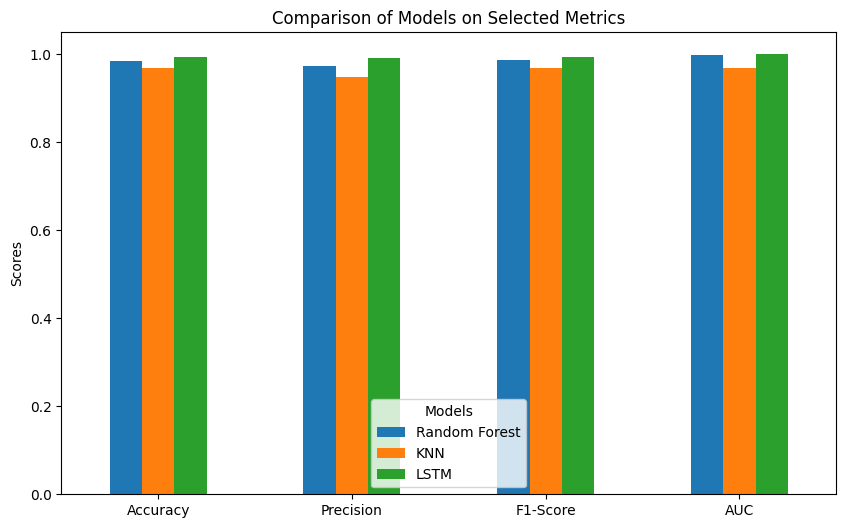

In [102]:
import matplotlib.pyplot as plt

# Select specific metrics to compare
metrics_to_plot = ["Accuracy", "Precision", "F1-Score", "AUC"]

results_summary.loc[metrics_to_plot].plot(kind="bar", figsize=(10, 6))
plt.title("Comparison of Models on Selected Metrics")
plt.ylabel("Scores")
plt.xticks(rotation=0)
plt.legend(title="Models")
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


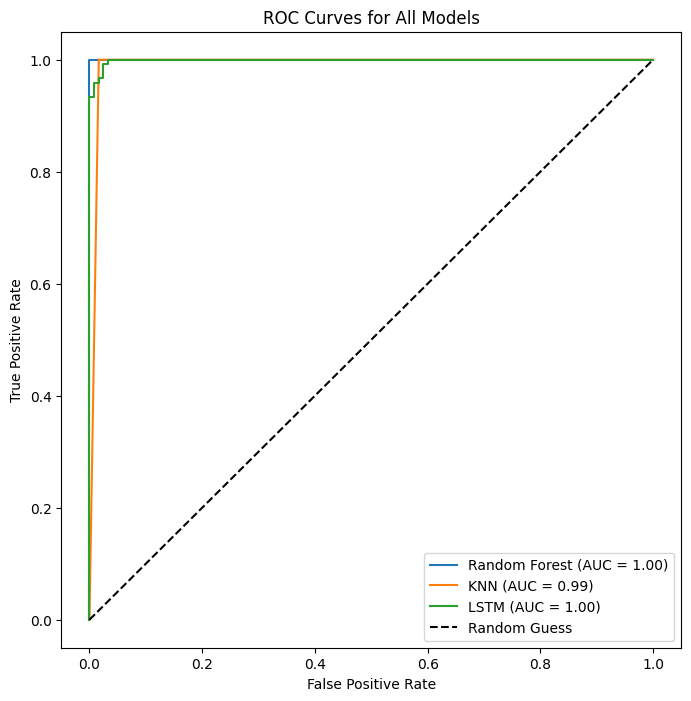

In [103]:
from sklearn.metrics import roc_curve

# Random Forest ROC Curve
y_prob_rf = rf_model.predict_proba(X_test_scaled)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

# KNN ROC Curve
y_prob_knn = knn_model.predict_proba(X_test_scaled)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)

# LSTM ROC Curve
X_test_lstm = np.expand_dims(X_test_scaled.values, axis=-1)
y_prob_lstm = lstm_model.predict(X_test_lstm).flatten()
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_prob_lstm)

# Plot all ROC curves
plt.figure(figsize=(8, 8))
plt.plot(fpr_rf, tpr_rf, label="Random Forest (AUC = {:.2f})".format(roc_auc_score(y_test, y_prob_rf)))
plt.plot(fpr_knn, tpr_knn, label="KNN (AUC = {:.2f})".format(roc_auc_score(y_test, y_prob_knn)))
plt.plot(fpr_lstm, tpr_lstm, label="LSTM (AUC = {:.2f})".format(roc_auc_score(y_test, y_prob_lstm)))
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.title("ROC Curves for All Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()